In [2]:
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Team
from basketball_reference_web_scraper.data import OutputType
import pandas as pd
import datetime as datetime
from datetime import datetime, timedelta
from dateutil.parser import parse
from pulp import *
import numpy as np
from sklearn import linear_model
import os.path
from os import path
import seaborn as sns

In [ ]:
for m in range(1, 3):
    if m == 2:
        for d in range(1, 29):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)
    else:
        for d in range(1, 32):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)

In [41]:
client.player_box_scores(day=31, month=7, year=2020)

InvalidDate: Date with year set to 2020, month set to 7, and day set to 31 is invalid

In [3]:
all_tables = []
for m in range(1, 3):
    if m == 2:
        for d in range(1, 29):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            table  = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

    else:
        for d in range(1, 32):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            table  = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

In [4]:
full_df = all_tables[0]
for i in range(1, len(all_tables)):
    current_table = all_tables[i]
    full_df = full_df.append(current_table)
full_df.to_csv("./OutputCSVs/all_games.csv")

In [5]:
df = pd.read_csv("./OutputCSVs/updated_team_stats.csv")
df["team"] = df["team"].str.upper()
all_games = pd.read_csv("./OutputCSVs/all_games.csv")

team_def = []
team_pace = []
team_tov = []
opp_def = []
opp_pace = []
opp_tov = []
all_games_teams = all_games[["team", "opponent"]]

for i in range(len(all_games_teams)):
    game = all_games_teams.loc[i]
    team = game["team"]
    opponent = game["opponent"]
    team_def.append(df[df["team"] == team]["drtg"].iloc[0])
    team_pace.append(df[df["team"] == team]["pace"].iloc[0])
    team_tov.append(df[df["team"] == team]["tov%"].iloc[0])
    opp_def.append(df[df["team"] == opponent]["drtg"].iloc[0])
    opp_pace.append(df[df["team"] == opponent]["pace"].iloc[0])
    opp_tov.append(df[df["team"] == opponent]["tov%"].iloc[0])
    
all_games["Team Defensive Rating"] = team_def
all_games["Team Pace"] = team_pace
all_games["Team Turnover %"] = team_tov
all_games["Opponent Defensive Rating"] = opp_def
all_games["Opponent Pace"] = opp_pace
all_games["Opponent Turnover %"] = opp_tov

all_games.to_csv("./OutputCSVs/all_games_new.csv")
df = pd.read_csv("./OutputCSVs/all_games_new.csv")
attempted_2s = df["attempted_field_goals"] - df["attempted_three_point_field_goals"]
made_2s = df["made_field_goals"] - df["made_three_point_field_goals"]
rebounds = df["offensive_rebounds"] + df["defensive_rebounds"]
at_home = df["location"] == "HOME"
df["attempted_two_point_field_goals"] = attempted_2s
df["made_two_point_field_goals"] = made_2s
df["total_rebounds"] = rebounds
df["at_home"] = at_home
df.to_csv("./OutputCSVs/all_games_updated.csv")
all_games_actual = pd.read_csv("./OutputCSVs/all_games_updated.csv")
all_games_actual =  all_games_actual.iloc[:, 3:].reset_index()

In [6]:
def get_stats(player, date, number_rows):
    converted_datetime = datetime.strptime(date, '%Y-%m-%d')
    player_rows = all_games_actual.loc[all_games_actual['name'] == player]
    #print(player_rows)
    selected_rows = []
    if (len(player_rows)) < number_rows:
        for i in range(len(player_rows)):
            selected_rows.append(player_rows.iloc[i])
        return pd.DataFrame(selected_rows)
    index = 0
    for i in range(len(player_rows)):
        curr_date = player_rows.iloc[i]['Date']
        if datetime.strptime(curr_date, '%Y-%m-%d') >= converted_datetime:
            index = i - 1
            break
    if index != 0:
        if index + 1 - number_rows < 0:
            for i in range(index + 1):
                selected_rows.append(player_rows.iloc[i])
        else:
            for i in range(index + 1 - number_rows, index + 1):
                selected_rows.append(player_rows.iloc[i])
#     elif converted_datetime >= players_rows[len(player_rows) - 1]:
    else:
        for i in range(len(player_rows) - number_rows, len(player_rows)):
            selected_rows.append(player_rows.iloc[i])
    return pd.DataFrame(selected_rows)

In [7]:
def get_points(row_data):
    three_pt_fgs = row_data['made_three_point_field_goals']
    two_pt_fgs = row_data['made_two_point_field_goals']
    made_fts = row_data['made_free_throws']
    total_rebounds = row_data['rebounds']
    assists = row_data['assists']
    blocks = row_data['blocks']
    steals = row_data['steals']
    turnovers = row_data['turnovers']
    FD_points = three_pt_fgs * 3 + two_pt_fgs * 2 + made_fts + total_rebounds * 1.2 + assists * 1.5 + blocks * 3 + steals * 3 - turnovers
    FD_dollars = FD_points * 200
    return (FD_points, FD_dollars)

In [8]:
def weight_function(statistic, weight):
    s = 0
    if type(statistic) == np.ndarray:
        for i in range(len(statistic)):
            s += statistic[len(statistic) - i - 1] * (weight ** i)
    else:
        for i in range(len(statistic)):
            s += statistic.iloc[len(statistic) - i - 1,] * (weight ** i)
    return s

In [87]:
def time_weighted_average(rows, statistic, weight):
    if rows.empty:
        return 0
    stat = rows[statistic]
    this_num = 1 / weight_function(np.ones(len(stat)), weight)
    return this_num * weight_function(stat, weight)
player_box_scores = pd.read_csv('./OutputCSVs/all_games_updated.csv')

input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %", 'Team Defensive Rating', 'Team Pace', 'Team Turnover %', 'Opponent Pace']

In [18]:
def statline_predictor(player_box_scores, input_statistics, sample_size = 5, weight = .8):
    player_box_scores = player_box_scores[~player_box_scores.index.duplicated()]
    player_box_scores.reindex(range(len(player_box_scores)), axis = "index")
    predicted_statlines = pd.DataFrame(index = player_box_scores.index, columns = input_statistics).fillna(0).T
    index_len = len(player_box_scores.index)
    for box_index in player_box_scores.index:
        box_score = player_box_scores.loc[box_index]
        player_name = box_score["name"]
        game_date = str(box_score["Date"])[:10]
        last_n_rows = get_stats(player_name, game_date, sample_size)
        weighted_stats = [player_name, box_score["team"], game_date, box_score["location"], box_score["opponent"]]
        for stat in input_statistics[5:]:
            weighted_stats.append(round(time_weighted_average(last_n_rows, stat, weight), 2))
        predicted_statlines[box_index] = weighted_stats
    return predicted_statlines.T

In [11]:
predictions_samplesize5 = statline_predictor(all_games_actual, input_statistics, sample_size = 5)
predictions_samplesize5.to_csv("./OutputCSVs/predicted_statlines_trailing_5_games.csv")
predictions_samplesize10 = statline_predictor(all_games_actual, input_statistics, sample_size = 10)
predictions_samplesize10.to_csv("./OutputCSVs/predicted_statlines_trailing_10_games.csv")

In [19]:
def rebound_predictor_5(weighted_stats):
    if "offensive_rebounds_y" in weighted_stats.index:
        return 3.495 + .9489 * weighted_stats["offensive_rebounds_y"] + .2874 * weighted_stats["defensive_rebounds_y"]
    else:
        return 3.495 + .9489 * weighted_stats["offensive_rebounds"] + .2874 * weighted_stats["defensive_rebounds"]
def freethrow_predictor_5(weighted_stats):
    if "attempted_free_throws_y" in weighted_stats.index:
        return 1.373 + .6217 * weighted_stats["attempted_free_throws_y"] + -.0373 * weighted_stats["attempted_field_goals_y"] -.3289 * (weighted_stats["location_y"] == "HOME")
    else:
        return 1.373 + .6217 * weighted_stats["attempted_free_throws"] + -.0373 * weighted_stats["attempted_field_goals"] -.3289 * (weighted_stats["location"] == "HOME")
def twopt_predictor_5(weighted_stats):
    if "attempted_field_goals_y" in weighted_stats.index:
        return max(0, -5.395 + .6064 * weighted_stats["attempted_two_point_field_goals_y"] - .2542 * weighted_stats["attempted_field_goals_y"] + .071 * weighted_stats["Opponent Defensive Rating"])
    else:
        return max(0, -5.395 + .6064 * weighted_stats["attempted_two_point_field_goals"] - .2542 * weighted_stats["attempted_field_goals"] + .071 * weighted_stats["Opponent Defensive Rating"])
def threept_predictor_5(weighted_stats):
    if "attempted_three_point_field_goals_y" in weighted_stats.index:
        return .766 + .214 * weighted_stats["attempted_three_point_field_goals_y"]
    else:
        return .766 + .214 * weighted_stats["attempted_three_point_field_goals"]
def assist_predictor_5(weighted_stats):
    if "assists_y" in weighted_stats.index:
        return 2.06 + .532 * weighted_stats["assists_y"] - .064 * weighted_stats["blocks_y"]
    else:
        return 2.06 + .532 * weighted_stats["assists"] - .064 * weighted_stats["blocks"]
def block_predictor_5(weighted_stats):
    if "offensive_rebounds_y" in weighted_stats.index:
        return .329 + .182 * weighted_stats["offensive_rebounds_y"] - .038 * weighted_stats["defensive_rebounds_y"] + .424 * weighted_stats["blocks_y"]
    else:
        return .329 + .182 * weighted_stats["offensive_rebounds"] - .038 * weighted_stats["defensive_rebounds"] + .424 * weighted_stats["blocks"]
def steal_predictor_5(weighted_stats):
    if "steals_y" in weighted_stats.index:
        return max(0, -.936 + .339 * weighted_stats["steals_y"] + .129 * weighted_stats["Opponent Turnover %"])
    else:
        return max(0, -.936 + .339 * weighted_stats["steals"] + .129 * weighted_stats["Opponent Turnover %"])
def turnover_predictor_5(weighted_stats):
    if "turnovers_y" in weighted_stats.index:
        return max(0, -2.589 + .18 * weighted_stats["turnovers_y"] + .121 * weighted_stats["assists_y"] + .032 * weighted_stats["Opponent Defensive Rating"])
    else:
        return max(0, -2.589 + .18 * weighted_stats["turnovers"] + .121 * weighted_stats["assists"] + .032 * weighted_stats["Opponent Defensive Rating"])
def minutes_predictor(weighted_stats):
    if "seconds_played_y" in weighted_stats.index:
        return np.mean(weighted_stats["seconds_played_y"])/60
    else:
        return np.mean(weighted_stats["seconds_played"])/60
def recent_average(weighted_stats):
    if "made_three_point_field_goals_y" in weighted_stats.index:
        return 3*np.mean(weighted_stats["made_three_point_field_goals_y"]) + 2*np.mean(weighted_stats["made_two_point_field_goals_y"]) + np.mean(weighted_stats["made_free_throws_y"]) + 1.2*(np.mean(weighted_stats["offensive_rebounds_y"]) + np.mean(weighted_stats["defensive_rebounds_y"])) + 1.5*np.mean(weighted_stats["assists_y"]) + 3*np.mean(weighted_stats["blocks_y"]) + 3*np.mean(weighted_stats["steals_y"]) - np.mean(weighted_stats["turnovers_y"])
    else:
        return 3*np.mean(weighted_stats["made_three_point_field_goals"]) + 2*np.mean(weighted_stats["made_two_point_field_goals"]) + np.mean(weighted_stats["made_free_throws"]) + 1.2*(np.mean(weighted_stats["offensive_rebounds"]) + np.mean(weighted_stats["defensive_rebounds"])) + 1.5*np.mean(weighted_stats["assists"]) + 3*np.mean(weighted_stats["blocks"]) + 3*np.mean(weighted_stats["steals"]) - np.mean(weighted_stats["turnovers"])

In [13]:
all_games_predicted_5 = pd.read_csv("./OutputCSVs/predicted_statlines_trailing_5_games.csv")
all_games_predicted_5 = all_games_predicted_5.rename(columns={"Unnamed: 0": "indexr"})
all_games_merged_5 = all_games_actual.merge(all_games_predicted_5, left_on="index", right_on="indexr")
all_games_predicted_10 = pd.read_csv("./OutputCSVs/predicted_statlines_trailing_10_games.csv")
all_games_predicted_10 = all_games_predicted_10.rename(columns={"Unnamed: 0": "indexr"})
all_games_merged_10 = all_games_actual.merge(all_games_predicted_10, left_on="index", right_on="indexr")
all_games_merged_5.to_csv("./OutputCSVs/true_and_predicted_statlines_5.csv")
all_games_merged_10.to_csv("./OutputCSVs/true_and_predicted_statlines_10.csv")

In [14]:
weighted_preds = pd.read_csv("./OutputCSVs/true_and_predicted_statlines_5.csv")

In [90]:
from sklearn.linear_model import RidgeCV

output_statistics = ["name", "team", "date", "location", "opponent", "minutes", "made_two_point_field_goals", "made_three_point_field_goals", "made_free_throws", "rebounds", "assists", "blocks", "steals", "turnovers", "recent_average"]

def statline_output(player_box_scores, input_statistics):
    weighted_lines_7_9 = statline_predictor(player_box_scores, input_statistics, 7, .9)
    weighted_lines_8_8 = statline_predictor(player_box_scores, input_statistics, 8, .8)
    weighted_lines_8_85 = statline_predictor(player_box_scores, input_statistics, 8, .85)
    weighted_lines_8_9 = statline_predictor(player_box_scores, input_statistics, 8, .9)
    weighted_lines_to_keep_7_9 = weighted_lines_7_9[weighted_lines_7_9.seconds_played > 1000]
    weighted_lines_to_keep_8_8 = weighted_lines_8_8[weighted_lines_8_8.seconds_played > 1000]
    weighted_lines_to_keep_8_85 = weighted_lines_8_85[weighted_lines_8_85.seconds_played > 1000]
    weighted_lines_to_keep_8_9 = weighted_lines_8_9[weighted_lines_8_9.seconds_played > 1000]
    df_to_keep = player_box_scores[weighted_lines_8_85.seconds_played > 1000]
    df_to_keep["attempted_two_point_field_goals"] = df_to_keep["attempted_field_goals"] - df_to_keep["attempted_three_point_field_goals"]
    df_to_keep["made_two_point_field_goals"] = df_to_keep["made_field_goals"] - df_to_keep["made_three_point_field_goals"]
    weighted_lines_to_keep_7_9['name_date'] = weighted_lines_to_keep_7_9["name"] + weighted_lines_to_keep_7_9["date"].astype(str)
    weighted_lines_to_keep_8_8['name_date'] = weighted_lines_to_keep_8_8["name"] + weighted_lines_to_keep_8_8["date"].astype(str)
    weighted_lines_to_keep_8_85['name_date'] = weighted_lines_to_keep_8_85["name"] + weighted_lines_to_keep_8_85["date"].astype(str)
    weighted_lines_to_keep_8_9['name_date'] = weighted_lines_to_keep_8_9["name"] + weighted_lines_to_keep_8_9["date"].astype(str)
    df_to_keep['name_date'] = df_to_keep["name"] + df_to_keep["Date"].astype(str)
    df_merged_7_9 = weighted_lines_to_keep_7_9.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_7_9["rebounds_y"] = df_merged_7_9["offensive_rebounds_y"] + df_merged_7_9["defensive_rebounds_y"]
    df_merged_7_9["location_x"] = df_merged_7_9["location_x"] == "HOME"
    df_merged_7_9["location_y"] = df_merged_7_9["location_y"] == "HOME"
    df_merged_8_8 = weighted_lines_to_keep_8_8.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_8["rebounds_y"] = df_merged_8_8["offensive_rebounds_y"] + df_merged_8_8["defensive_rebounds_y"]
    df_merged_8_8["location_x"] = df_merged_8_8["location_x"] == "HOME"
    df_merged_8_8["location_y"] = df_merged_8_8["location_y"] == "HOME"
    df_merged_8_85 = weighted_lines_to_keep_8_85.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_85["rebounds_y"] = df_merged_8_85["offensive_rebounds_y"] + df_merged_8_85["defensive_rebounds_y"]
    df_merged_8_85["location_x"] = df_merged_8_85["location_x"] == "HOME"
    df_merged_8_85["location_y"] = df_merged_8_85["location_y"] == "HOME"
    df_merged_8_9 = weighted_lines_to_keep_8_9.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_9["rebounds_y"] = df_merged_8_9["offensive_rebounds_y"] + df_merged_8_9["defensive_rebounds_y"]
    df_merged_8_9["location_x"] = df_merged_8_9["location_x"] == "HOME"
    df_merged_8_9["location_y"] = df_merged_8_9["location_y"] == "HOME"
    predictors_7_9 = df_merged_7_9.iloc[:,[3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25]]
    predictors_8_8 = df_merged_8_8.iloc[:,[3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25]]
    predictors_8_85 = df_merged_8_85.iloc[:,[3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25]]
    predictors_8_9 = df_merged_8_9.iloc[:,[3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25]]
    print(len(df_merged_8_8.columns), df_merged_8_8.columns)
    freethrows = df_merged_7_9.iloc[:,38]
    twopoints = df_merged_8_8.iloc[:,56]
    threepoints = df_merged_8_85.iloc[:,36]
    blocks = df_merged_8_85.iloc[:,44]
    assists = df_merged_8_9.iloc[:,42]
    rebounds = df_merged_8_9.iloc[:,57]
    turnovers = df_merged_8_9.iloc[:,45]
    seconds = df_merged_8_9.iloc[:,33]
    steals = df_merged_8_9.iloc[:,43]
    freethrow_model = RidgeCV().fit(predictors_7_9, freethrows)
    twopoint_model = RidgeCV().fit(predictors_8_8, twopoints)
    threepoint_model = RidgeCV().fit(predictors_8_85, threepoints)
    block_model = RidgeCV().fit(predictors_8_85, blocks)
    assist_model = RidgeCV().fit(predictors_8_9, assists)
    rebound_model = RidgeCV().fit(predictors_8_9, rebounds)
    turnover_model = RidgeCV().fit(predictors_8_9, turnovers)
    second_model = RidgeCV().fit(predictors_8_9, seconds)
    steal_model = RidgeCV().fit(predictors_8_9, steals)
    
    output_statlines = pd.DataFrame(index = weighted_lines_8_85.index, columns = output_statistics).fillna(0)
    output_statlines["name"] = weighted_lines_8_85["name"]
    output_statlines["team"] = weighted_lines_8_85["team"]
    output_statlines["date"] = weighted_lines_8_85["date"]
    output_statlines["location"] = weighted_lines_8_85["location"]
    output_statlines["opponent"] = weighted_lines_8_85["opponent"]
    weighted_lines_7_9["location"] = weighted_lines_7_9["location"] == "HOME"
    weighted_lines_8_8["location"] = weighted_lines_8_8["location"] == "HOME"
    weighted_lines_8_85["location"] = weighted_lines_8_85["location"] == "HOME"
    weighted_lines_8_9["location"] = weighted_lines_8_9["location"] == "HOME"
    weighted_lines_7_9 = weighted_lines_7_9.iloc[:, [3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25]]
    weighted_lines_8_8 = weighted_lines_8_8.iloc[:, [3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25]]
    weighted_lines_8_85 = weighted_lines_8_85.iloc[:, [3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25]]
    weighted_lines_8_9 = weighted_lines_8_9.iloc[:, [3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25]]

    output_statlines["minutes"] = second_model.predict(weighted_lines_8_9) / 60
    output_statlines["made_two_point_field_goals"] = twopoint_model.predict(weighted_lines_8_8)
    output_statlines["made_three_point_field_goals"] = threepoint_model.predict(weighted_lines_8_85) 
    output_statlines["made_free_throws"] = freethrow_model.predict(weighted_lines_7_9)
    output_statlines["rebounds"] = rebound_model.predict(weighted_lines_8_9)
    output_statlines["assists"] = assist_model.predict(weighted_lines_8_9)
    output_statlines["blocks"] = block_model.predict(weighted_lines_8_85)
    output_statlines["steals"] = steal_model.predict(weighted_lines_8_9) 
    output_statlines["turnovers"] = turnover_model.predict(weighted_lines_8_9)
    for box_index in output_statlines.index:
        pred_minutes = max(0, output_statlines.loc[box_index, "minutes"])
        if pred_minutes <= 19:
            output_statlines.loc[box_index, "made_two_point_field_goals"] = output_statlines.loc[box_index, "made_two_point_field_goals"] * pred_minutes/19
            output_statlines.loc[box_index, "made_three_point_field_goals"] = output_statlines.loc[box_index, "made_three_point_field_goals"] * pred_minutes/19
            output_statlines.loc[box_index, "made_free_throws"] = output_statlines.loc[box_index, "made_free_throws"] * pred_minutes/19
            output_statlines.loc[box_index, "rebounds"] = output_statlines.loc[box_index, "rebounds"] * pred_minutes/19
            output_statlines.loc[box_index, "assists"] = output_statlines.loc[box_index, "assists"] * pred_minutes/19
            output_statlines.loc[box_index, "blocks"] = output_statlines.loc[box_index, "blocks"] * pred_minutes/19
            output_statlines.loc[box_index, "steals"] = output_statlines.loc[box_index, "steals"] * pred_minutes/19
            output_statlines.loc[box_index, "turnovers"] = output_statlines.loc[box_index, "turnovers"] * pred_minutes/19
        output_statlines.loc[box_index, "minutes"] = pred_minutes
        output_statlines.loc[box_index, "made_two_point_field_goals"] = max(0, output_statlines.loc[box_index, "made_two_point_field_goals"])
        output_statlines.loc[box_index, "made_three_point_field_goals"] = max(0, output_statlines.loc[box_index, "made_three_point_field_goals"])
        output_statlines.loc[box_index, "made_free_throws"] = max(0, output_statlines.loc[box_index, "made_free_throws"])
        output_statlines.loc[box_index, "rebounds"] = max(0, output_statlines.loc[box_index, "rebounds"])
        output_statlines.loc[box_index, "assists"] = max(0, output_statlines.loc[box_index, "assists"])
        output_statlines.loc[box_index, "blocks"] = max(0, output_statlines.loc[box_index, "blocks"])
        output_statlines.loc[box_index, "steals"] = max(0, output_statlines.loc[box_index, "steals"])
        output_statlines.loc[box_index, "turnovers"] = max(0, output_statlines.loc[box_index, "turnovers"])
        output_statlines.loc[box_index, "recent_average"] = np.mean([recent_average(weighted_lines_8_85.loc[box_index]), recent_average(weighted_lines_8_9.loc[box_index]), recent_average(weighted_lines_8_8.loc[box_index]), recent_average(weighted_lines_7_9.loc[box_index])])
    return output_statlines

In [22]:
jan_feb_data = pd.read_csv('./OutputCSVs/predicted_statlines_jan_feb_2020.csv')
FD_points_array = []
FD_dollars_array = []
sum_points = 0
counter = 0
for index, row in jan_feb_data.iterrows():
    tuple_values = get_points(row)
    FD_points_array.append(tuple_values[0])
    FD_dollars_array.append(tuple_values[1])
    sum_points += tuple_values[0]
    counter += 1
jan_feb_data['FanDuel_Points'] = FD_points_array
jan_feb_data['FanDuel_Dollars'] = FD_dollars_array
jan_feb_data.to_csv("./OutputCSVs/Jan_Feb_statline_with_FanDuel_dollars.csv")

In [21]:
def generate_optimal_lineup(players, positions, values, costs, budget):
    num_variables = len(players)
    
    lp = LpProblem("My LP Problem", pulp.LpMaximize)
    
    d = {}
    for i in range(0, num_variables):
        d[players[i]] = LpVariable(players[i], cat="Binary")
    
    objective = sum(np.array(values) * np.array(list(d.values())))
    lp += objective
    
    pg_constraint = 0
    sg_constraint = 0
    sf_constraint = 0
    pf_constraint = 0
    c_constraint = 0
    for i in range(0, len(positions)):
        if positions[i] == "PG":
            pg_constraint += d[players[i]]
        elif positions[i] == "SG":
            sg_constraint += d[players[i]]
        elif positions[i] == "SF":
            sf_constraint += d[players[i]]
        elif positions[i] == "PF":
            pf_constraint += d[players[i]]
        else:
            c_constraint += d[players[i]]
    lp += pg_constraint == 2
    lp += sg_constraint == 2
    lp += sf_constraint == 2
    lp += pf_constraint == 2
    lp += c_constraint == 1
    
    cost = sum(np.array(costs) * np.array(list(d.values())))
    lp += cost <= budget
    
    lp.solve()
    
    lineup = [variable.name for variable in lp.variables() if variable.varValue == 1]
    print(lineup)
    #for variable in lp.variables():
    #    print ("{} = {}".format(variable.name, variable.varValue))
    #print(pulp.value(lp.objective))

In [22]:
def box_scores_for_range_of_days(start_date, end_date):
    all_tables = []
    start_month = start_date.month
    end_month = end_date.month
    for m in range(start_month, end_month + 1):
        if m == start_month:
            start_day = start_date.day
        else:
            start_day = 1
        if m == end_month:
            end_day = end_date.day
        else:
            if m == 2:
                end_day = 29
            elif m in [9, 4, 6, 11]:
                end_day = 30
            else:
                end_day = 31
        
        for d in range(start_day, end_day + 1):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            if not path.exists(file_name):
                continue
            if pd.read_csv(file_name).empty:
                client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)
            table = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

    full_df = all_tables[0]
    for i in range(1, len(all_tables)):
        current_table = all_tables[i]
        full_df = full_df.append(current_table)
    
    full_df.index = range(full_df.shape[0])
    df = pd.read_csv("./OutputCSVs/updated_team_stats.csv")
    df["team"] = df["team"].str.upper()

    team_def = []
    team_pace = []
    team_tov = []
    opp_def = []
    opp_pace = []
    opp_tov = []
    all_games_teams = full_df[["team", "opponent"]]

    for i in range(len(all_games_teams)):
        game = all_games_teams.loc[i]
        team = game["team"].upper()
        opponent = game["opponent"].upper()
        team_def.append(df[df["team"] == team]["drtg"].iloc[0])
        team_pace.append(df[df["team"] == team]["pace"].iloc[0])
        team_tov.append(df[df["team"] == team]["tov%"].iloc[0])
        opp_def.append(df[df["team"] == opponent]["drtg"].iloc[0])
        opp_pace.append(df[df["team"] == opponent]["pace"].iloc[0])
        opp_tov.append(df[df["team"] == opponent]["tov%"].iloc[0])
    
    full_df["Team Defensive Rating"] = team_def
    full_df["Team Pace"] = team_pace
    full_df["Team Turnover %"] = team_tov
    full_df["Opponent Defensive Rating"] = opp_def
    full_df["Opponent Pace"] = opp_pace
    full_df["Opponent Turnover %"] = opp_tov
    return full_df

In [81]:
def make_predictions(start_date, end_date, output = True):
    input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %", 'Team Defensive Rating', 'Team Pace', 'Team Turnover %', 'Opponent Pace']
    full_df = box_scores_for_range_of_days(start_date, end_date)
    predicted_statlines = statline_output(full_df, input_statistics)
    if output:
        output_filename = './AllCSVs/' + str(start_date.month) + '_' + str(start_date.day) + '_' + str(end_date.month) + '_' + str(end_date.day) + '_2020_predicted_box_scores.csv'
        predicted_statlines.to_csv(output_filename)
    return predicted_statlines

make_predictions(datetime(2020, 2, 1), datetime(2020, 2, 11), output = True)

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

43.609739428623456
32.267104544283875
35.23126907785079
24.984533929794807
34.12884764295782
40.41334836886201
21.872252735996266
30.373626681536447
28.633194378350968
27.449189378603243
27.033983435127496
30.041023035170443
33.44884031867354
24.156738253296126
28.857986053257903
36.06239799634029
34.67348475994208
24.90113674637157
31.295698776628377
32.48405788705979
28.612814669045907
21.477658303753422
28.11049114433656
32.53082405296522
28.720462540915076
32.39239723890588
39.20172051818978
29.899110276504263
31.646818234589652
26.608733898009927
34.44139271586946
36.77457697751712
19.017812194035574
37.83949395145335
26.23081328990035
25.153420569860675
28.126803120024345
21.97982352777928
25.004765329431926
23.570632174200206
34.766904387029896
34.60289545811806
18.94258449807279
22.4560555643669
34.11933013592158
34.37066629460058
25.350629237625512
24.456751436332176
23.859391086505546
22.516065768259455
26.882693407716104
21.353136738151758
23.012624724329786
29.3323801564245

18.924497943041782
17.36766385034978
15.800211555996224
22.992312881335444
17.24283037783945
31.38247050662938
17.590461464431556
23.274136244422586
18.118521610140206
16.539408498831236
16.331630937352436
24.695041832699623
20.11026222989792
33.33680787354557
19.58041164609582
23.215259528080516
15.154055540220977
23.223736072091363
16.052810570453858
15.899391160623932
17.290918245808907
25.707431640263454
21.33744595080427
19.036723700181355
25.487904209309097
23.557352196045585
26.88393672572466
25.563257700699623
19.020973667490402
19.234968664428568
25.25275432217705
23.293731976501068
20.579130289393788
23.216214619263997
16.82949261041352
18.539315301106466
23.817974008739125
17.858792252590128
20.553389028596857
28.440520032194666
22.944700567321675
19.862396331063344
18.69201076413437
20.392468541358532
22.803759875647735
19.88239319919577
30.72284490645834
21.79788531374837
37.94352674623978
38.357719434959996
39.81473620389336
38.13899328078545
31.54097634783923
28.67528304

29.77096783202059
31.576291214765707
28.39878270218639
25.48388207232038
21.69238400999902
22.3412035135503
15.573391836363813
22.81348873781848
28.158385221134893
23.704558654946897
25.860892694952426
30.51976799962334
25.27047185753786
18.50993047970396
33.787519428715385
35.03212342760762
30.505428254504363
33.47401313102672
24.614106800639767
25.48665557984491
19.455957681154874
19.042320773112912
36.245376176279414
34.56614035029049
23.01421679255296
23.919790309190148
32.63860532330292
25.241898011520597
25.933330322910972
27.4366050018899
32.7081284358301
22.64877212892622
20.406529258974977
26.426899246499563
24.01973590259395
25.90596624839902
19.68758110750385
27.461951344565097
16.45269346701851
17.04924992101631
33.97410325178897
25.183362684264672
17.2247695153571
28.946076872907422
25.04728347449314
25.759235604768364
21.537685722799722
23.266050089081016
15.986409964439272
24.978366815508153
19.06195374338733
29.923512734311714
18.359173404833864
19.915470392671317
24.44

17.505809744246456
13.505934106926903
22.807424081203877
24.12670244910236
21.001064042650103
18.335697659769018
16.869090299529287
18.625602718331802
30.33070207922958
21.94448122585669
24.77029673627469
20.175552178482107
17.86073770049304
15.986409964439272
20.63358956720704
20.699258525511663
15.850721021600473
31.28987681876006
28.596526956330916
22.543084152885044
28.47215527114337
32.24354978263636
32.63892091091922
33.900946648241415
29.020106586008726
32.77965350872808
25.321456073332737
29.190656926198592
29.98805656658145
41.06169190626509
31.211718470636228
32.87142353524451
31.636029005598065
23.951231460599583
26.956935528710307
38.42505184247822
28.95158790399421
33.32991976638343
32.66612776857841
36.473814063647986
29.842941713869664
26.27125954528001
25.435115434992273
31.297041052313848
33.65819874818363
20.601420616932106
27.323706546940684
27.515521321852365
28.815539901389116
21.05642889057658
23.819885899714208
35.41548720247665
24.83030869597203
25.2871415682884

,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average
0,Damian Lillard,PORTLAND TRAIL BLAZERS,2020-02-01,HOME,UTAH JAZZ,43.609739,6.981645,4.490638,7.261680,5.261765,8.499766,0.328734,1.300382,3.126899,66.87100
1,Bradley Beal,WASHINGTON WIZARDS,2020-02-01,HOME,BROOKLYN NETS,32.267105,6.921862,2.789434,7.214674,3.581753,5.411681,0.419085,0.977772,2.606377,49.55250
2,Karl-Anthony Towns,MINNESOTA TIMBERWOLVES,2020-02-01,AWAY,LOS ANGELES CLIPPERS,35.231269,7.083754,2.415190,5.077316,7.932547,3.651902,1.012167,0.877692,2.832429,45.76425
3,Dorian Finney-Smith,DALLAS MAVERICKS,2020-02-01,HOME,ATLANTA HAWKS,24.984534,1.760449,1.519326,1.239558,6.394387,1.001953,0.667666,0.691134,0.618549,20.67375
4,Anthony Davis,LOS ANGELES LAKERS,2020-02-01,AWAY,SACRAMENTO KINGS,34.128848,6.886112,1.157143,4.234391,10.133366,3.527816,1.824523,1.060660,2.140114,51.53625
5,Kawhi Leonard,LOS ANGELES CLIPPERS,2020-02-01,HOME,MINNESOTA TIMBERWOLVES,40.413348,8.348971,2.577814,5.767778,8.057473,5.425127,1.170089,1.425798,3.033040,61.21125
6,Jalen Brunson,DALLAS MAVERICKS,2020-02-01,HOME,ATLANTA HAWKS,21.872253,3.016990,0.663229,1.507549,2.444875,2.315294,0.190356,0.644724,0.785195,16.24950
7,Jaylen Brown,BOSTON CELTICS,2020-02-01,HOME,PHILADELPHIA 76ERS,30.373627,4.763533,2.033831,3.582846,5.183111,3.413288,0.353099,0.932333,2.014411,31.40450
8,DeMar DeRozan,SAN ANTONIO SPURS,2020-02-01,HOME,CHARLOTTE HORNETS,28.633194,8.230793,0.357310,6.576224,6.602348,5.491619,0.280924,1.050427,2.294515,43.28825
9,Cody Zeller,CHARLOTTE HORNETS,2020-02-01,AWAY,SAN ANTONIO SPURS,27.449189,4.077058,0.544926,1.189898,5.914004,2.176533,0.565655,0.635927,1.508016,22.69225


In [24]:
import pytz

def predict_next_day(start_date, game_date):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and game['start_time'].month == game_date.month]
    team_objs_on_date = [game["home_team"] for game in schedule_on_date] + [game["away_team"] for game in schedule_on_date]
    teams_on_date = [t.name.replace("_", " ") for t in team_objs_on_date]
    predictions_for_date = make_predictions(start_date, game_date, output = False)
    players_on_date = predictions_for_date[predictions_for_date.team.isin(teams_on_date)]
    mstr, dstr = str(game_date.month), str(game_date.day)
    if game_date.month < 10:
        mstr = "0" + mstr
    if game_date.day < 10:
        dstr = "0" + dstr
    tstr = mstr + "-" + dstr
    statlines_on_date = players_on_date[players_on_date.date.str.contains(tstr)]
    statlines_on_date.index = range(statlines_on_date.shape[0])
    output_filename = './AllCSVs/predictions_for_' + mstr + "_" + dstr + '_from_' + str(start_date.month) + '_' + str(start_date.day) + '_2020.csv'
    statlines_on_date.to_csv(output_filename)
    return statlines_on_date
predict_next_day(datetime(2020, 2, 1), datetime(2020, 2, 12))

,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average
0,T.J. Warren,INDIANA PACERS,2020-02-12,HOME,MILWAUKEE BUCKS,30.8353,5.47898,1.13408,3.64134,4.3516,2.68364,0.5115,1.48461,1.15303,27.633
1,Aaron Gordon,ORLANDO MAGIC,2020-02-12,HOME,DETROIT PISTONS,34.4602,4.99512,1.73542,3.44812,7.71761,4.4518,0.77934,1.27833,1.76711,37.629
2,Andrew Wiggins,GOLDEN STATE WARRIORS,2020-02-12,AWAY,PHOENIX SUNS,32.9885,3.97306,1.91732,4.95377,5.1045,3.93808,0.58656,1.5666,1.93808,32.614
3,Luka Dončić,DALLAS MAVERICKS,2020-02-12,HOME,SACRAMENTO KINGS,31.9093,4.61314,2.71126,4.7777,6.47619,5.0132,0.39632,1.22544,2.1253,44.766
4,Kristaps Porziņģis,DALLAS MAVERICKS,2020-02-12,HOME,SACRAMENTO KINGS,30.9818,2.99724,2.62138,6.37248,7.06805,2.5982,0.77462,1.42383,1.38155,46.337
5,Tristan Thompson,CLEVELAND CAVALIERS,2020-02-12,HOME,ATLANTA HAWKS,23.7022,4.20088,0.93506,1.66283,8.43243,2.90648,0.81716,1.04166,1.37334,20.38
6,Brandon Clarke,MEMPHIS GRIZZLIES,2020-02-12,HOME,PORTLAND TRAIL BLAZERS,22.9283,4.98684,0.99498,2.23169,6.34291,2.52532,0.73782,1.11732,1.34905,21.643
7,LeBron James,LOS ANGELES LAKERS,2020-02-12,AWAY,DENVER NUGGETS,33.2082,4.33512,2.27898,3.55023,6.22527,7.83752,0.13096,1.33473,3.32978,45.436
8,Larry Nance,CLEVELAND CAVALIERS,2020-02-12,HOME,ATLANTA HAWKS,28.2375,3.22063,1.64982,0.834482,6.62359,3.44464,0.57254,0.97329,1.46184,23.34
9,Anthony Davis,LOS ANGELES LAKERS,2020-02-12,AWAY,DENVER NUGGETS,33.289,7.13924,1.04206,5.83771,7.46696,4.05076,0.9372,1.56186,1.85281,49.583


In [25]:
def append_actual_results(start_date, game_date):
    predicted_results = predict_next_day(start_date, game_date)
    actual_results = box_scores_for_range_of_days(game_date, game_date)
    actual_results["made_two_point_field_goals"] = actual_results["made_field_goals"] - actual_results["made_three_point_field_goals"]
    actual_results["rebounds"] = actual_results["offensive_rebounds"] + actual_results["defensive_rebounds"]
    pred_outputs = [float(get_points(predicted_results[predicted_results["name"] == player_name])[0]) for player_name in predicted_results["name"]]
    actual_outputs = [float(get_points(actual_results[actual_results["name"] == player_name])[0]) for player_name in predicted_results["name"]]
    predicted_results["predicted_points"] = pred_outputs
    predicted_results["actual_points"] = actual_outputs
    output_filename = './AllCSVs/' + str(game_date.month) + '_' + str(game_date.day) + '_2020_box_scores_predicted_with_actual.csv'
    predicted_results.to_csv(output_filename)
    return predicted_results

append_actual_results(datetime(2020, 2, 1), datetime(2020, 2, 12))

,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average,predicted_points,actual_points
0,T.J. Warren,INDIANA PACERS,2020-02-12,HOME,MILWAUKEE BUCKS,30.8353,5.47898,1.13408,3.64134,4.3516,2.68364,0.5115,1.48461,1.15303,27.633,32.084212,54.9
1,Aaron Gordon,ORLANDO MAGIC,2020-02-12,HOME,DETROIT PISTONS,34.4602,4.99512,1.73542,3.44812,7.71761,4.4518,0.77934,1.27833,1.76711,37.629,38.989354,54.3
2,Andrew Wiggins,GOLDEN STATE WARRIORS,2020-02-12,AWAY,PHOENIX SUNS,32.9885,3.97306,1.91732,4.95377,5.1045,3.93808,0.58656,1.5666,1.93808,32.614,35.205767,55.3
3,Luka Dončić,DALLAS MAVERICKS,2020-02-12,HOME,SACRAMENTO KINGS,31.9093,4.61314,2.71126,4.7777,6.47619,5.0132,0.39632,1.22544,2.1253,44.766,40.168957,55.4
4,Kristaps Porziņģis,DALLAS MAVERICKS,2020-02-12,HOME,SACRAMENTO KINGS,30.9818,2.99724,2.62138,6.37248,7.06805,2.5982,0.77462,1.42383,1.38155,46.337,37.823860,58.1
5,Tristan Thompson,CLEVELAND CAVALIERS,2020-02-12,HOME,ATLANTA HAWKS,23.7022,4.20088,0.93506,1.66283,8.43243,2.90648,0.81716,1.04166,1.37334,20.38,31.551525,44.7
6,Brandon Clarke,MEMPHIS GRIZZLIES,2020-02-12,HOME,PORTLAND TRAIL BLAZERS,22.9283,4.98684,0.99498,2.23169,6.34291,2.52532,0.73782,1.11732,1.34905,21.643,30.806142,44.7
7,LeBron James,LOS ANGELES LAKERS,2020-02-12,AWAY,DENVER NUGGETS,33.2082,4.33512,2.27898,3.55023,6.22527,7.83752,0.13096,1.33473,3.32978,45.436,39.351302,64.4
8,Larry Nance,CLEVELAND CAVALIERS,2020-02-12,HOME,ATLANTA HAWKS,28.2375,3.22063,1.64982,0.834482,6.62359,3.44464,0.57254,0.97329,1.46184,23.34,28.516130,52.4
9,Anthony Davis,LOS ANGELES LAKERS,2020-02-12,AWAY,DENVER NUGGETS,33.289,7.13924,1.04206,5.83771,7.46696,4.05076,0.9372,1.56186,1.85281,49.583,43.923222,58.0


In [26]:
def alternate_contests(start_date, game_date, search_datetime, inclusive):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and (game['start_time'] - timedelta(hours = 4)).month == game_date.month]
    times_on_date = np.unique([game['start_time'] - timedelta(hours = 4) for game in schedule_on_date])
    print(times_on_date)
    if not inclusive:
        game_teams = [game["home_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) == search_datetime] + [game["away_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) == search_datetime]
    else:
        times_after_search = [t for t in times_on_date if 60 * t.hour + t.minute >= 60 * search_datetime.hour + search_datetime.minute]
        game_teams = [game["home_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) in times_after_search] + [game["away_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) in times_after_search]
    game_team_strings = [str(team)[5:].replace("_", " ") for team in game_teams]
    predictions_for_date = predict_next_day(start_date, game_date)
    players_on_date = predictions_for_date[predictions_for_date.team.isin(game_team_strings)]
    output_filename = './AllCSVs/' + str(game_date.month) + '_' + str(game_date.day) + '_2020_alternate_' + str(search_datetime.hour) + "_" + str(search_datetime.minute) + '.csv'
    players_on_date.to_csv(output_filename)
    return players_on_date
alternate_contests(datetime(2020, 1, 1), datetime(2020, 1, 13), datetime(2020, 1, 13, 21, 30), True)

[datetime.datetime(2020, 1, 13, 20, 0, tzinfo=<UTC>)
 datetime.datetime(2020, 1, 13, 20, 30, tzinfo=<UTC>)
 datetime.datetime(2020, 1, 13, 21, 0, tzinfo=<UTC>)
 datetime.datetime(2020, 1, 13, 23, 0, tzinfo=<UTC>)
 datetime.datetime(2020, 1, 13, 23, 30, tzinfo=<UTC>)]


,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average
0,Nemanja Bjelica,SACRAMENTO KINGS,2020-01-13,HOME,ORLANDO MAGIC,32.7828,2.82729,1.8895,1.85892,7.10537,3.09476,0.4803,1.24878,1.51673,28.999
1,De'Aaron Fox,SACRAMENTO KINGS,2020-01-13,HOME,ORLANDO MAGIC,34.3728,6.46037,1.5685,4.14368,5.63168,6.0166,0.86476,1.76067,2.60771,46.233
2,LeBron James,LOS ANGELES LAKERS,2020-01-13,HOME,CLEVELAND CAVALIERS,34.0525,6.21717,2.08424,3.83806,7.70982,6.88348,0.35788,1.3536,2.67783,57.219
6,Devonte' Graham,CHARLOTTE HORNETS,2020-01-13,AWAY,PORTLAND TRAIL BLAZERS,35.261,2.30633,2.59998,3.23651,4.47805,5.86884,0.46934,1.38783,2.33677,32.721
7,Damian Lillard,PORTLAND TRAIL BLAZERS,2020-01-13,HOME,CHARLOTTE HORNETS,35.0217,3.36084,2.6171,4.24142,4.90104,5.91928,0.54096,1.10403,2.1325,41.094
8,Dwight Howard,LOS ANGELES LAKERS,2020-01-13,HOME,CLEVELAND CAVALIERS,20.2685,4.18294,0.80666,2.88782,8.05127,2.3626,1.66728,0.93441,1.29505,29.725
11,CJ McCollum,PORTLAND TRAIL BLAZERS,2020-01-13,HOME,CHARLOTTE HORNETS,32.0728,4.26619,2.15058,1.81765,4.7129,4.17024,0.54652,1.13682,1.50784,30.308
12,Evan Fournier,ORLANDO MAGIC,2020-01-13,AWAY,SACRAMENTO KINGS,31.6595,3.03447,2.26828,3.18901,4.34297,3.86644,0.36,1.51224,1.68605,29.607
13,Nikola Vučević,ORLANDO MAGIC,2020-01-13,AWAY,SACRAMENTO KINGS,31.2717,5.66474,1.9109,2.53213,10.1623,3.76804,0.96944,1.30884,1.70393,45.035
14,P.J. Washington,CHARLOTTE HORNETS,2020-01-13,AWAY,PORTLAND TRAIL BLAZERS,30.8808,3.5558,1.27532,2.34535,5.22693,3.4282,0.4125,1.03188,1.62481,20.075


In [91]:
def matchup_lookup(matchups, team):
    matchup = [m for m in matchups if team in m][0]
    if team == matchup[0]:
        return matchup[1]
    else:
        return matchup[0]

def predict_unplayed_games(start_date, game_date):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and (game['start_time'] - timedelta(hours = 4)).month == game_date.month]
    available_box_scores = box_scores_for_range_of_days(start_date, game_date)
    game_teams = [game["home_team"] for game in schedule_on_date] + [game["away_team"] for game in schedule_on_date]
    matchups = [[str(game["home_team"])[5:].replace("_", " "), str(game["away_team"])[5:].replace("_", " ")] for game in schedule_on_date]
    game_team_strings = [str(team)[5:].replace("_", " ") for team in game_teams]
    relevant_lines = available_box_scores[available_box_scores.team.isin(game_team_strings)]
    relevant_players = relevant_lines.drop_duplicates(subset = ["name"])
    mstr, dstr = str(game_date.month), str(game_date.day)
    if game_date.month < 10:
        mstr = "0" + mstr
    if game_date.day < 10:
        dstr = "0" + dstr
    tstr = str(game_date.year) + "-" + mstr + "-" + dstr
    relevant_players.Date = [tstr for _ in range(len(relevant_players))]
    relevant_players.location = ["AWAY" for _ in range(len(relevant_players))]
    relevant_players.opponent = [matchup_lookup(matchups, t) for t in relevant_players.team]
    augmented_box_scores = available_box_scores.append(relevant_players)
    augmented_box_scores.index = range(augmented_box_scores.shape[0])
    print(len(augmented_box_scores.columns), augmented_box_scores.columns)
    predicted_statlines = statline_output(augmented_box_scores, input_statistics)
    statlines_on_date = predicted_statlines[predicted_statlines.date.str.contains(tstr)]
    statlines_on_date['projected_points'] = [float(get_points(statlines_on_date[statlines_on_date["name"] == player_name])[0]) for player_name in statlines_on_date.name]
    output_filename = './AllCSVs/predictions_for_' + mstr + "_" + dstr + "_2020_unplayed.csv"
    statlines_on_date.to_csv(output_filename)
    return statlines_on_date
    
july_30_predictions = predict_unplayed_games(datetime(2020, 2, 1), datetime(2020, 7, 30))
july_30_predictions

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


28 Index(['slug', 'name', 'team', 'location', 'opponent', 'outcome',
       'seconds_played', 'made_field_goals', 'attempted_field_goals',
       'made_three_point_field_goals', 'attempted_three_point_field_goals',
       'made_free_throws', 'attempted_free_throws', 'offensive_rebounds',
       'defensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers',
       'personal_fouls', 'game_score', 'Date', 'Team Defensive Rating',
       'Team Pace', 'Team Turnover %', 'Opponent Defensive Rating',
       'Opponent Pace', 'Opponent Turnover %'],
      dtype='object')


c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

58 Index(['name_x', 'team_x', 'date', 'location_x', 'opponent_x',
       'made_field_goals_x', 'made_two_point_field_goals_x',
       'attempted_two_point_field_goals_x', 'attempted_field_goals_x',
       'made_three_point_field_goals_x', 'attempted_three_point_field_goals_x',
       'attempted_free_throws_x', 'made_free_throws_x', 'offensive_rebounds_x',
       'defensive_rebounds_x', 'assists_x', 'blocks_x', 'turnovers_x',
       'steals_x', 'seconds_played_x', 'Opponent Defensive Rating_x',
       'Opponent Turnover %_x', 'Team Defensive Rating_x', 'Team Pace_x',
       'Team Turnover %_x', 'Opponent Pace_x', 'name_date', 'slug', 'name_y',
       'team_y', 'location_y', 'opponent_y', 'outcome', 'seconds_played_y',
       'made_field_goals_y', 'attempted_field_goals_y',
       'made_three_point_field_goals_y', 'attempted_three_point_field_goals_y',
       'made_free_throws_y', 'attempted_free_throws_y', 'offensive_rebounds_y',
       'defensive_rebounds_y', 'assists_y', 'steals_y', '

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average,projected_points
4948,Anthony Davis,LOS ANGELES LAKERS,2020-07-30,AWAY,LOS ANGELES CLIPPERS,32.785491,5.354669,1.204239,8.459765,7.973149,4.405131,1.446303,1.943716,2.185410,54.99825,46.941940
4949,Kawhi Leonard,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,31.323652,6.006101,4.190525,6.099200,7.126328,4.744136,0.164178,0.862862,1.764889,46.27400,47.667007
4950,Bojan Bogdanović,UTAH JAZZ,2020-07-30,AWAY,NEW ORLEANS PELICANS,25.559610,1.807626,3.640086,2.959915,1.486695,1.616757,0.074392,0.695208,0.582208,21.60725,23.431187
4951,Paul George,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,24.281042,4.484620,1.948652,1.600271,4.056077,3.768487,0.266557,1.254992,1.222251,27.90625,30.277884
4952,Donovan Mitchell,UTAH JAZZ,2020-07-30,AWAY,NEW ORLEANS PELICANS,30.244184,5.741733,3.680472,3.311007,2.734012,3.046831,0.000000,0.672793,1.268404,38.98750,34.436924
4953,LeBron James,LOS ANGELES LAKERS,2020-07-30,AWAY,LOS ANGELES CLIPPERS,39.712553,6.360551,1.686422,2.657926,9.544025,9.980286,0.423818,1.566184,2.871568,51.29300,49.959994
4954,Rajon Rondo,LOS ANGELES LAKERS,2020-07-30,AWAY,LOS ANGELES CLIPPERS,25.502731,2.690386,1.872143,0.404273,3.412994,4.107940,0.797516,0.830272,1.624029,19.02150,24.918315
4955,Mike Conley,UTAH JAZZ,2020-07-30,AWAY,NEW ORLEANS PELICANS,26.391457,2.445772,3.572642,0.764463,2.280699,3.585178,0.061918,0.580961,1.160995,27.81425,25.256180
4956,Kentavious Caldwell-Pope,LOS ANGELES LAKERS,2020-07-30,AWAY,LOS ANGELES CLIPPERS,24.062708,1.750436,3.223480,1.503852,2.512569,1.616916,0.357578,0.820342,0.831148,18.21475,22.818235
4957,Avery Bradley,LOS ANGELES LAKERS,2020-07-30,AWAY,LOS ANGELES CLIPPERS,21.994445,2.259472,3.312964,0.589049,2.202105,1.587948,0.278378,0.690553,0.623482,17.93875,22.354644


In [89]:
#july_30_predictions = predict_unplayed_games(datetime(2020, 2, 20), datetime(2020, 7, 30))
len(july_30_predictions)

61

In [ ]:
def optimal_lineup_games(input_games, ):

In [37]:
from random import sample

for sample_size in range(6, 11):
    dates = sample(range(30), 5)
    errors = []
    for date in dates:
        game_date = datetime(2020, 2, date)
        print(game_date)
        results = append_actual_results(datetime(2020, 1, 2), game_date, sample_size)
        errors.append(np.mean((results.actual_points - results.predicted_points)**2))

        print(errors)

2020-02-11 00:00:00
2020-02-17 00:00:00
2020-02-02 00:00:00
2020-02-24 00:00:00
2020-02-04 00:00:00
[148.82838502050967, nan, 139.60488782064257, 142.8418045969123, 146.57561312068572]
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-10 00:00:00
[116.62257633648109, 137.511663253122, 141.54689884144622, 112.3495570579943, 115.21090394674252]
2020-02-19 00:00:00
2020-02-09 00:00:00
2020-02-16 00:00:00
2020-02-02 00:00:00
2020-02-23 00:00:00
[nan, 158.11006119379758, nan, 138.41111557349737, 151.29273243164425]
2020-02-24 00:00:00


KeyboardInterrupt: 

In [51]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %"]
def regression_by_sample(start_date, end_date, sample_size, weight):
    full_df = box_scores_for_range_of_days(start_date, end_date)
    weighted_statlines = statline_predictor(full_df, input_statistics, sample_size, weight)
    weighted_statlines_to_keep = weighted_statlines[weighted_statlines.seconds_played > 1000]
    df_to_keep = full_df[weighted_statlines.seconds_played > 1000]
    df_to_keep["attempted_two_point_field_goals"] = df_to_keep["attempted_field_goals"] - df_to_keep["attempted_three_point_field_goals"]
    df_to_keep["made_two_point_field_goals"] = df_to_keep["made_field_goals"] - df_to_keep["made_three_point_field_goals"]
    weighted_statlines_to_keep['name_date'] = weighted_statlines_to_keep["name"] + weighted_statlines_to_keep["date"].astype(str)
    df_to_keep['name_date'] = df_to_keep["name"] + df_to_keep["Date"].astype(str)
    df_merged = weighted_statlines_to_keep.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged["rebounds_y"] = df_merged["offensive_rebounds_y"] + df_merged["defensive_rebounds_y"]
    df_merged["location_x"] = df_merged["location_x"] == "HOME"
    df_merged["location_y"] = df_merged["location_y"] == "HOME"
    df_merged = df_merged[df_merged.Date.astype(str).str.contains("2020-02")]
    predictors = df_merged.iloc[:,[3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 45, 46, 47, 49]]
    print(df_merged.columns[[3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 45, 46, 47, 49]])
    for desired_output in [34, 39, 41]:
        y = df_merged.iloc[:,desired_output]
        pred_train, pred_test, y_train, y_test = train_test_split(predictors, y, test_size=0.2, random_state=758)
        pred_train1, pred_test1, y_train1, y_test1 = train_test_split(predictors, y, test_size=0.2, random_state=3)
        pred_train2, pred_test2, y_train2, y_test2 = train_test_split(predictors, y, test_size=0.2, random_state=2690)
        pred_train3, pred_test3, y_train3, y_test3 = train_test_split(predictors, y, test_size=0.2, random_state=467)
        pred_train4, pred_test4, y_train4, y_test4 = train_test_split(predictors, y, test_size=0.2, random_state=9999)
        pred_train5, pred_test5, y_train5, y_test5 = train_test_split(predictors, y, test_size=0.2, random_state=34715)
        pred_train6, pred_test6, y_train6, y_test6 = train_test_split(predictors, y, test_size=0.2, random_state=88)
        ridge_model = RidgeCV().fit(pred_train, y_train)
        linear_model = LinearRegression().fit(pred_train, y_train)
        ridge_model1 = RidgeCV().fit(pred_train1, y_train1)
        linear_model1 = LinearRegression().fit(pred_train1, y_train1)
        ridge_model2 = RidgeCV().fit(pred_train2, y_train2)
        linear_model2 = LinearRegression().fit(pred_train2, y_train2)
        ridge_model3 = RidgeCV().fit(pred_train3, y_train3)
        linear_model3 = LinearRegression().fit(pred_train3, y_train3)
        ridge_model4 = RidgeCV().fit(pred_train4, y_train4)
        linear_model4 = LinearRegression().fit(pred_train4, y_train4)
        ridge_model5 = RidgeCV().fit(pred_train5, y_train5)
        linear_model5 = LinearRegression().fit(pred_train5, y_train5)
        ridge_model6 = RidgeCV().fit(pred_train6, y_train6)
        linear_model6 = LinearRegression().fit(pred_train6, y_train6)
        print(df_merged.columns[desired_output])
        print(ridge_model.score(pred_test, y_test))
        print(linear_model.score(pred_test, y_test))
        print(ridge_model1.score(pred_test1, y_test1))
        print(linear_model1.score(pred_test1, y_test1))
        print(ridge_model2.score(pred_test2, y_test2))
        print(linear_model2.score(pred_test2, y_test2))
        print(ridge_model3.score(pred_test3, y_test3))
        print(linear_model3.score(pred_test3, y_test3))
        print(ridge_model4.score(pred_test4, y_test4))
        print(linear_model4.score(pred_test4, y_test4))
        print(ridge_model5.score(pred_test5, y_test5))
        print(linear_model5.score(pred_test5, y_test5))
        print(ridge_model6.score(pred_test6, y_test6))
        print(linear_model6.score(pred_test6, y_test6))
    #return df_merged
for i, j in [(7, .9), (8, .8), (8, .85), (8, .9)]:
        regression_by_sample(datetime(2020, 1, 2), datetime(2020, 2, 29), i, j)

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Index(['location_x', 'made_two_point_field_goals_x',
       'attempted_two_point_field_goals_x', 'made_three_point_field_goals_x',
       'attempted_three_point_field_goals_x', 'attempted_free_throws_x',
       'made_free_throws_x', 'offensive_rebounds_x', 'defensive_rebounds_x',
       'assists_x', 'blocks_x', 'turnovers_x', 'steals_x',
       'Opponent Defensive Rating_x', 'Opponent Turnover %_x',
       'Team Defensive Rating', 'Team Pace', 'Team Turnover %',
       'Opponent Pace'],
      dtype='object')
made_free_throws_y
0.23567432456459336
0.23514909491502956
0.33746994334465796
0.337495009625406
0.2724195699027734
0.27216515775086214
0.32486657188959056
0.3247832670335611
0.3648558477920564
0.36487218808073474
0.26637156877887147
0.2663321832043152
0.3466979116079769
0.3463980603855963
steals_y
0.01881449047210293
0.018462922968845663
0.08393890512245938
0.08437958642805299
0.028376970413394376
0.02799609663299174
0.03236771121308535
0.03203538118391003
0.019456553053990744
0.0

KeyboardInterrupt: 

In [56]:
#feb_12_pred_actual = append_actual_results(datetime(2020, 1, 17), datetime(2020, 2, 12))
jan_24_pred_actual = append_actual_results(datetime(2020, 1, 1), datetime(2020, 1, 24))
jan_24_predictions = predict_next_day(datetime(2020, 1, 1), datetime(2020, 1, 24))
late_jan_box_scores = box_scores_for_range_of_days(datetime(2020, 1, 24), datetime(2020, 1, 31))

In [99]:
#july_30_predictions.groupby(["team"]).sum()
july_30_predictions[july_30_predictions["team"] == "LOS ANGELES CLIPPERS"]
#sns.distplot(july_30_predictions.projected_points)
#sns.distplot(july_30_predictions.recent_average)

,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average,projected_points
4949,Kawhi Leonard,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,31.323652,6.006101,4.190525,6.099200,7.126328,4.744136,0.164178,0.862862,1.764889,46.27400,47.667007
4951,Paul George,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,24.281042,4.484620,1.948652,1.600271,4.056077,3.768487,0.266557,1.254992,1.222251,27.90625,30.277884
4959,Patrick Beverley,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,23.687917,1.651388,1.272024,0.000000,4.721811,3.349262,0.804736,1.053436,1.291682,17.58400,22.091750
4960,Montrezl Harrell,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,22.604654,5.255198,0.000000,3.010924,6.989843,1.382484,1.280422,0.506033,1.962565,33.55500,27.379656
4962,Lou Williams,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,28.179474,5.262796,1.404664,1.865954,4.208926,5.244477,0.488976,1.229360,2.103289,29.26525,32.574681
4965,Ivica Zubac,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,20.508417,3.103394,0.399553,1.051756,7.417126,1.395233,1.397755,0.452398,1.646529,20.10850,23.354531
4966,Landry Shamet,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,21.972386,1.096998,2.179631,1.318832,1.854404,1.410912,0.138976,0.953437,0.340717,16.39300,17.329896
4971,JaMychal Green,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,19.704129,1.430088,1.539953,0.914262,5.738136,0.835264,0.844126,0.691878,0.692982,15.26275,20.447984
4978,Rodney McGruder,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,16.540825,1.999117,0.000000,0.000000,1.910898,0.000000,0.635184,0.335258,0.544800,5.06775,8.657836
4981,Maurice Harkless,LOS ANGELES CLIPPERS,2020-07-30,AWAY,LOS ANGELES LAKERS,18.673190,0.817956,0.105464,0.000000,2.636694,0.000000,0.533932,0.400796,0.584251,16.18875,7.336270


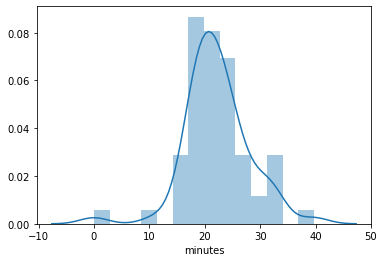

In [93]:
#late_jan_box_scores["minutes"] = late_jan_box_scores["seconds_played"] / 60
# sns.distplot(jan_24_pred_actual.minutes)
# sns.distplot(july_31_predictions.minutes)
sns.distplot(july_30_predictions.minutes)
# sns.distplot(feb_12_pred_actual.minutes)
#sns.jointplot(data = feb_12_pred_actual, x = 'predicted_points', y = 'actual_points', kind = 'reg')
#sns.jointplot(data = jan_24_pred_actual, x = 'predicted_points', y = 'actual_points', kind = 'reg')
# sns.distplot(feb_12_pred_actual.actual_points)
# sns.distplot(feb_12_pred_actual.predicted_points)

In [22]:
all_abbrv = {'ATLANTA HAWKS':'Atlanta', 'BOSTON CELTICS':'Boston', 'BROOKLYN NETS':'Brooklyn', 'CHARLOTTE HORNETS':'Charlotte', 'CHICAGO BULLS':'Chicago', 'CLEVELAND CAVALIERS':'Cleveland', 'DALLAS MAVERICKS':'Dallas',
            'DENVER NUGGETS':'Denver', 'DETROIT PISTONS':'Detroit', 'GOLDEN STATE WARRIORS':'Golden State', 'HOUSTON ROCKETS':'Houston', 'INDIANA PACERS':'Indiana', 'LOS ANGELES CLIPPERS':'LA Clippers', 'LOS ANGELES LAKERS':'LA Lakers',
            'MEMPHIS GRIZZLIES':'Memphis', 'MIAMI HEAT':'Miami', 'MILWAUKEE BUCKS':'Milwaukee', 'MINNESOTA TIMBERWOLVES':'Minnesota', 'NEW ORLEANS PELICANS':'New Orleans', 'NEW YORK KNICKS':'New York', 'OKLAHOMA CITY THUNDER':'Oklahoma City', 'ORLANDO MAGIC':'Orlando',
            'PHILADELPHIA 76ERS':'Philadelphia', 'PHOENIX SUNS':'Phoenix', 'PORTLAND TRAIL BLAZERS':'Portland', 'SAC':'Sacramento', 'SAN ANTONIO SPURS':'San Antonio', 'TORONTO RAPTORS':'Toronto', 'UTAH JAZZ':'Utah', 'WASHINGTON WIZARDS':'Washington'}
dkp = pd.read_csv('./OutputCSVs/draftkings_points.csv')
dkp = dkp[pd.isna(dkp.position)==False]
dbp = pd.read_csv('./OutputCSVs/team_def_vs_position.csv')

ranks = []
seen = {}
player_names = [seen.setdefault(x, x) for x in dkp['name'] if x not in seen]
abbrv = [str(dkp.loc[dkp['name']==x, 'team'].iloc[0]).upper() for x in player_names]
player_positions = [dkp.loc[dkp['name']==x, 'position'].iloc[0] for x in player_names]
team_names = [all_abbrv.get(x) for x in abbrv]

for i in range(0, len(player_names)):
    if len(player_positions[i])<=2:
        ranks.append(dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i])].iloc[0])
    else:
        first_subrank =  dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i][:2])].iloc[0]
        second_subrank =  dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i][3:])].iloc[0]
        ranks.append((first_subrank + second_subrank)/2)

outputDefense = pd.DataFrame({'name':player_names, 'pos':player_positions, 'team':team_names, 'rank':ranks})
outputDefense.to_csv('./OutputCSVs/player_def_vs_position.csv', header=True, index=False)

In [44]:
import unicodedata

def strip_accents(text):
    text = unicodedata.normalize('NFD', text) .encode('ascii', 'ignore').decode("utf-8")
    return str(text)

team_def_vs_pos = []
opp_def_vs_pos = []
all_abbrv = {'ATLANTA HAWKS':'Atlanta', 'BOSTON CELTICS':'Boston', 'BROOKLYN NETS':'Brooklyn', 'CHARLOTTE HORNETS':'Charlotte', 'CHICAGO BULLS':'Chicago', 'CLEVELAND CAVALIERS':'Cleveland', 'DALLAS MAVERICKS':'Dallas',
            'DENVER NUGGETS':'Denver', 'DETROIT PISTONS':'Detroit', 'GOLDEN STATE WARRIORS':'Golden State', 'HOUSTON ROCKETS':'Houston', 'INDIANA PACERS':'Indiana', 'LOS ANGELES CLIPPERS':'LA Clippers', 'LOS ANGELES LAKERS':'LA Lakers',
            'MEMPHIS GRIZZLIES':'Memphis', 'MIAMI HEAT':'Miami', 'MILWAUKEE BUCKS':'Milwaukee', 'MINNESOTA TIMBERWOLVES':'Minnesota', 'NEW ORLEANS PELICANS':'New Orleans', 'NEW YORK KNICKS':'New York', 'OKLAHOMA CITY THUNDER':'Oklahoma City', 'ORLANDO MAGIC':'Orlando',
            'PHILADELPHIA 76ERS':'Philadelphia', 'PHOENIX SUNS':'Phoenix', 'PORTLAND TRAIL BLAZERS':'Portland', 'SACRAMENTO KINGS':'Sacramento', 'SAN ANTONIO SPURS':'San Antonio', 'TORONTO RAPTORS':'Toronto', 'UTAH JAZZ':'Utah', 'WASHINGTON WIZARDS':'Washington'}
main_df = pd.read_csv('./AllCSVs/predictions_for_07_31_2020_unplayed.csv')
dk_positions = pd.read_csv('./OutputCSVs/draftkings_points.csv')
dbp = pd.read_csv('./OutputCSVs/team_def_vs_position.csv')
dk_positions.dropna(subset=['position'],inplace=True)
player_positions = pd.Series(dk_positions.position.values,index=dk_positions.name).to_dict()
for i in range(len(main_df)):
    name = strip_accents(main_df['name'][i])
    position = player_positions.get(name)
    team = all_abbrv.get(main_df['team'][i])
    opponent = all_abbrv.get(main_df['opponent'][i])
    if position is None:
        team_def_vs_pos.append('NA')
        opp_def_vs_pos.append('NA')
    else:
        if len(position)<=2:
            team_def_vs_pos.append(dbp.loc[dbp['Team']==team, 'vs {0}'.format(position)].iloc[0])
            opp_def_vs_pos.append(dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position)].iloc[0])
        else:
            first_team_subrank =  dbp.loc[dbp['Team']==team, 'vs {0}'.format(position[:2])].iloc[0]
            second_team_subrank =  dbp.loc[dbp['Team']==team, 'vs {0}'.format(position[3:])].iloc[0]
            first_opp_subrank =  dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position[:2])].iloc[0]
            second_opp_subrank =  dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position[3:])].iloc[0]
            team_def_vs_pos.append((first_team_subrank + second_team_subrank)/2)
            opp_def_vs_pos.append((first_opp_subrank + second_opp_subrank)/2)
main_df['team def vs pos'] = team_def_vs_pos
main_df['opponent def vs pos'] = opp_def_vs_pos
main_df.to_csv('AllCSVs/predictions_for_07_31_2020_unplayed.csv')